# TINTO Hybrid Network with CNN classification

## Setup and Configuration (Run First)

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate

#from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_6840/2723279260.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/manwest/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Model Building (Run First)

(Base_line model + Vision model (Synthetic data)) -> MLP

### FFNN

In [34]:
class FFNNComponent:
    def __init__(
        self,
        filters_ffnn: [int],
        dropout_rate: float,
    ):
        self.filters_ffnn = filters_ffnn
        self.dropout_rate = dropout_rate
        self.ffnn = tf.keras.Sequential()
        for filters in self.filters_ffnn:
            self.ffnn.add(Dense(filters, activation='relu'))
            self.ffnn.add(BatchNormalization())
            self.ffnn.add(Dropout(self.dropout_rate))

    def __call__(
        self,
        x: tf.Tensor,
    ):
        x = self.ffnn(x)
        return x

### Transformer Encoder

In [35]:
class AddNorm(layers.Layer):
    """Layer normalization and dropout applied to the sum of inputs (residual connection)."""
    def __init__(
        self,
        dropout_rate: float = 0.1, 
        epsilon: float = 1e-12,
        **kwargs,
    ):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = layers.Dropout(dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=epsilon)

    def call(
        self,
        x: tf.Tensor,
        y: tf.Tensor,
    ):
        y = self.dropout(y)
        # Add & Norm (residual connection followed by layer normalization)
        return self.layer_norm(x + y)
    

In [36]:
class PositionWiseFFN(layers.Layer):
    """Position-wise feed-forward network."""
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        **kwargs,
    ):
        super(PositionWiseFFN, self).__init__(**kwargs)
        # First dense layer increases dimensionality from input_size to hidden_size and relu activation
        self.dense1 = layers.Dense(hidden_size, activation='relu')
        # Second dense layer projects back to input_size dimensions
        self.dense2 = layers.Dense(input_size)

    def call(
        self,
        x: tf.Tensor,
    ):
        x = self.dense1(x)
        x = self.dense2(x)
        return x


In [37]:
import time

In [38]:
import tensorflow as tf

class TransformerBlock(layers.Layer):
    """Encoder block of the Transformer model"""
    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        value_dim: int,
        output_dim: int,
        dropout: float,
        ffn_hidden_size: int,
        use_bias: bool =False,
    ):
        super(TransformerBlock, self).__init__()
        self.attention_head = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            value_dim=value_dim,
            output_shape=output_dim,
            dropout=dropout,
            use_bias=use_bias,
        )
        self.add_norm_1 = AddNorm(dropout)
        self.feed_forward = PositionWiseFFN(key_dim, ffn_hidden_size)
        self.add_norm_2 = AddNorm(dropout)

    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        attention = self.attention_head(x, x, x)
        x = self.add_norm_1(x, attention)
        x = self.add_norm_2(x, self.feed_forward(x))
            
        return x


In [39]:
class Encoder(layers.Layer):
    """Transformer block of the Transformer model"""
    def __init__(
        self,
        attention_num_heads: int,
        attention_key_dim: int,
        attention_value_dim: int,
        attention_output_dim: int,
        attention_dropout: float,
        ffn_hidden_size: int,
        num_layers: int,
        attention_use_bias: bool = False,
    ):
        super(Encoder, self).__init__()
        
        # Create a Sequential model to hold the encoder blocks
        self.encoder_blocks = tf.keras.Sequential()
        self.transformer_block = TransformerBlock

        for i in range(num_layers):
            # Add an EncoderBlock as a layer to the Sequential model
            self.encoder_blocks.add(
                self.transformer_block(
                    num_heads=attention_num_heads,
                    key_dim=attention_key_dim,
                    value_dim=attention_value_dim,
                    output_dim=attention_output_dim,
                    dropout=attention_dropout,
                    use_bias=attention_use_bias,
                    ffn_hidden_size=ffn_hidden_size,
                )
            )

    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        x = self.encoder_blocks(x)
        return x

In [40]:
class ResidualBlock(layers.Layer):
    """ResNet Residual block"""
    def __init__(
        self,
        filters: int,
        use_1x1conv=False,
        strides: int = 1,
        use_bias: bool = False,
    ):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", use_bias=use_bias)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", use_bias=use_bias)
        self.bn2 = layers.BatchNormalization()
        if use_1x1conv:
            self.conv3 = layers.Conv2D(filters, kernel_size=1, strides=3)
        else:
            self.conv3 = None
    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        if self.conv3:
            x = self.conv3(x)
        return self.relu(x + y)


### Encoder With Restnet

In [41]:
class ResNet(layers.Layer):
    """ResNet model"""
    def __init__(
        self,
    ):
        super(ResNet, self).__init__()
        
        self.b1 = tf.keras.Sequential([
            layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')
        ])
        self.b2 = tf.keras.Sequential(self.ResNetBlock(num_filters=128, num_blocks=2, first_block=True))
        self.b3 = tf.keras.Sequential(self.ResNetBlock(num_filters=64, num_blocks=2))
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(16, activation='relu')
        self.activation = tf.keras.layers.Activation('relu')
        self.flatten = tf.keras.layers.Flatten()

    def call(
        self,
        x: tf.Tensor,
        num_classes: int=None,
    ):
        # Define the model's forward pass
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.activation(x)
        if num_classes:
            x = layers.Dense(num_classes, activation='softmax')(x)
        return x
    
    # Define the ResNet blocks
    def ResNetBlock(
        self,
        num_filters: int,
        num_blocks: int,
        first_block=False
    ):
        blocks = []
        for i in range(num_blocks):
            if i == 0 and not first_block:
                blocks.append(ResidualBlock(num_filters, use_1x1conv=True, strides=2))
            else:
                blocks.append(ResidualBlock(num_filters))
        return blocks

In [42]:
class EncoderWithResNet(layers.Layer):
    """Custom layer that combines the Encoder block with a ResNet"""
    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        value_dim:  int,
        output_dim: int,
        ffn_hidden_size: int,
        dropout: float,
        num_layers: int,
        bias: bool = False,
    ):
        super(EncoderWithResNet, self).__init__()
        self.encoder = Encoder(
            attention_num_heads=num_heads,
            attention_key_dim=key_dim,
            attention_value_dim=value_dim,
            attention_output_dim=output_dim,
            attention_dropout=dropout,
            ffn_hidden_size=ffn_hidden_size,
            num_layers=num_layers,
            attention_use_bias=bias,
        )

        self.resnet = ResNet(
        )

    def call(
        self,
        x: tf.Tensor,
        num_classes: int=None,
    ):
        # Define the model's forward pass
        x_ffnn = []
        for i in range(x[1].shape[-1]):
            x_ffnn.append(self.encoder(x[1][:,:,:,i]))
        x = tf.stack(x_ffnn, axis=-1)

        x = self.resnet(x, num_classes)
        return x

In [43]:
class HNNRestNetModel(Model):
    """Hybrid Model that combines the FFNNComponent and the EncoderWithResNet"""
    def __init__(
        self,
        filters_ffnn: [int],
        dropout_rate: float,
        attention_num_heads: int,
        attention_key_dim: int,
        attention_value_dim: int,
        attention_output_dim: int,
        attention_dropout: float,
        ffn_hidden_size: int,
        encoder_num_layers: int,
        num_classes: int,
        attention_use_bias: bool = False,
    ):
        super(HNNRestNetModel, self).__init__()

        self.encoder_with_resnet = EncoderWithResNet(
            num_heads=attention_num_heads,
            key_dim=attention_key_dim,
            value_dim=attention_value_dim,
            output_dim=attention_output_dim,
            ffn_hidden_size=ffn_hidden_size,
            dropout=attention_dropout,
            num_layers=encoder_num_layers,
            bias=attention_use_bias,
        )

        self.ffnn = FFNNComponent(
            filters_ffnn=filters_ffnn,
            dropout_rate=dropout_rate,
        )

        self.fc = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        x_attention = self.encoder_with_resnet(x)
        x_ffnn = self.ffnn(x[0])
        merged = layers.Concatenate(axis=-1)([x_ffnn, x_attention])
        x = self.fc(merged)
        return x

### Encoder with CNN

In [44]:
class FFNNComponent:
    def __init__(
        self,
        filters_ffnn: [int],
        dropout_rate: float,
    ):
        self.filters_ffnn = filters_ffnn
        self.dropout_rate = dropout_rate
        self.ffnn = tf.keras.Sequential()
        for filters in self.filters_ffnn:
            self.ffnn.add(Dense(filters, activation='relu'))
            self.ffnn.add(BatchNormalization())
            self.ffnn.add(Dropout(self.dropout_rate))

    def __call__(
        self,
        x: tf.Tensor,
    ):
        x = self.ffnn(x)
        return x

In [45]:
class CNN(layers.Layer):
    """CNN model for images"""
    def __init__(
        self,
        filters_cnn: [int],
    ):
        super(CNN, self).__init__()
        self.cnn_model = tf.keras.Sequential()
        self.filters_cnn = filters_cnn
        
        for layer in self.filters_cnn:
            self.cnn_model.add(layers.Conv2D(layer, (3, 3), padding="same"))
            self.cnn_model.add(layers.Activation("relu"))
            self.cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        self.Dense1 = layers.Dense(128, activation='relu')
        self.Dense2 = layers.Dense(64, activation='relu')
        self.Dense3 = layers.Dense(32, activation='relu')
        self.flatten = tf.keras.layers.Flatten()

        

    def call(
        self,
        x: tf.Tensor,
        ):
        x = self.cnn_model(x)
        x = self.flatten(x)
        x = self.Dense1(x)
        x = self.Dense2(x)
        x = self.Dense3(x)
        return x


class EncoderWithCNN(layers.Layer):
    """Custom layer that combines the Encoder block with a CNN"""
    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        value_dim:  int,
        output_dim: int,
        ffn_hidden_size: int,
        dropout: float,
        num_layers: int,
        filters_cnn: [int],
        bias: bool = False,
    ):
        super(EncoderWithCNN, self).__init__()
        self.encoder = Encoder(
            attention_num_heads=num_heads,
            attention_key_dim=key_dim,
            attention_value_dim=value_dim,
            attention_output_dim=output_dim,
            attention_dropout=dropout,
            ffn_hidden_size=ffn_hidden_size,
            num_layers=num_layers,
            attention_use_bias=bias,
        )

        self.cnn = CNN(
            filters_cnn=filters_cnn,
        )

    def call(
        self,
        x: tf.Tensor,
        num_classes: int=None,
    ):
        # Define the model's forward pass
        x_ffnn = []
        for i in range(x[1].shape[-1]):
            x_ffnn.append(self.encoder(x[1][:,:,:,i]))
        x = tf.stack(x_ffnn, axis=-1)
        x = self.cnn(x)
        return x
    

In [46]:
class HNNCNNModel(Model):
    """Hybrid Model that combines the FFNNComponent and the EncoderWithResNet"""
    def __init__(
        self,
        filters_ffnn: [int],
        dropout_rate: float,
        attention_num_heads: int,
        attention_key_dim: int,
        attention_value_dim: int,
        attention_output_dim: int,
        attention_dropout: float,
        ffn_hidden_size: int,
        encoder_num_layers: int,
        filters_cnn: [int],
        num_classes: int,
        attention_use_bias: bool = False,
    ):
        super(HNNCNNModel, self).__init__()

        self.encoder_cnn = EncoderWithCNN(
            num_heads=attention_num_heads,
            key_dim=attention_key_dim,
            value_dim=attention_value_dim,
            output_dim=attention_output_dim,
            ffn_hidden_size=ffn_hidden_size,
            dropout=attention_dropout,
            num_layers=encoder_num_layers,
            filters_cnn=filters_cnn,
            bias=attention_use_bias,
        ) 

        self.ffnn = FFNNComponent(
            filters_ffnn=filters_ffnn,
            dropout_rate=dropout_rate,
        )

        self.fc = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])


    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        x_attention = self.encoder_cnn(x)
        x_ffnn = self.ffnn(x[0])
        merged = layers.Concatenate(axis=-1)([x_ffnn, x_attention])
        x = self.fc(merged)
        return x

### CNN Only 

In [47]:
class HNNCNNOnlyModel(Model):
    """Hybrid Model that combines the FFNNComponent and the EncoderWithResNet"""
    def __init__(
        self,
        filters_ffnn: [int],
        dropout_rate: float,
        filters_cnn: [int],
        num_classes: int,
    ):
        super(HNNCNNOnlyModel, self).__init__()

        self.cnn = CNN(
            filters_cnn=filters_cnn,
        )

        self.ffnn = FFNNComponent(
            filters_ffnn=filters_ffnn,
            dropout_rate=dropout_rate,
        )

        self.fc = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(
        self,
        x: tf.Tensor,
    ):
        # Define the model's forward pass
        x_attention = self.cnn(x[1])
        x_ffnn = self.ffnn(x[0])
        merged = layers.Concatenate(axis=-1)([x_ffnn, x_attention])
        x = self.fc(merged)
        return x

## Full Training Example

### Data Loading

In [48]:
#Select the model and the parameters
# problem_type: supervised, unsupervised or regeression
problem_type = "supervised"
# default TINTO image 20x20
image_model = TINTO(problem= problem_type,blur=True)
pixel_size = 20

#Define the dataset path and the folder where the images will be saved
dataset_path = "/Users/manwest/Git/TINTOlib/Pruebas/Datasets/winequality-red.csv"
images_folder = "Wine_Images"

In [49]:
#Read CSV
df = pd.read_csv(dataset_path, sep=';')
df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [50]:
#Generate thet images
image_model.generateImages(df, images_folder)
img_paths = os.path.join(images_folder,problem_type+".csv")
print(img_paths)

Wine_Images/supervised.csv


In [51]:
# Read images
imgs = pd.read_csv(img_paths)

imgs["images"]= images_folder + "/" + imgs["images"]

In [52]:
imgs.head(2)

,images,class
0,Wine_Images/5.0/000000.png,5.0
1,Wine_Images/5.0/000001.png,5.0


In [53]:
# Select all the attributes to normalize
columns_to_normalize = df.columns[:-1]

# Normalize between 0 and 1
df_normalized = (df[columns_to_normalize] - df[columns_to_normalize].min()) / (df[columns_to_normalize].max() - df[columns_to_normalize].min())

# Combine the attributes and the label
df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

df_normalized.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.0,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5
1,0.283186,0.520548,0.0,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5


In [54]:
combined_dataset = pd.concat([imgs,df_normalized],axis=1)

In [55]:
combined_dataset.head(2)

,images,class,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Wine_Images/5.0/000000.png,5.0,0.247788,0.397260,0.0,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5
1,Wine_Images/5.0/000001.png,5.0,0.283186,0.520548,0.0,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5


In [56]:
combined_dataset = pd.concat([imgs,df_normalized],axis=1)
# df_x drop the class and label columns
df_x = combined_dataset.drop("class",axis=1).drop("quality",axis=1)
# df_y get class column
df_y = combined_dataset["class"]

print(df_y)

0       5.0
1       5.0
2       5.0
3       6.0
4       5.0
       ... 
1594    5.0
1595    6.0
1596    6.0
1597    5.0
1598    6.0
Name: class, Length: 1599, dtype: float64


In [57]:
# Encode class values as integers, when multi-class classification problem
from tensorflow.keras.utils import to_categorical

encoder = sklearn.preprocessing.LabelEncoder()
df_y_int = encoder.fit_transform(df_y)

# Now convert integer-encoded labels to one-hot encoding
df_y_onehot = to_categorical(df_y_int)

In [58]:
df_y_onehot

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

### Data Splitting

In [59]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y_onehot, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 canal (RGB)
X_train_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_train["images"]])
X_val_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_val["images"]])
X_test_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_test["images"]])

# For 1 canal (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

attributes = len(X_train_num.columns)
imgs_shape = X_train_img[0].shape

print("Images shape: ",imgs_shape)
print("Attributes: ",attributes)
pixels=X_train_img[0].shape[0]
print("Image size (pixels):", pixels)

Images shape:  (20, 20, 3)
Attributes:  11
Image size (pixels): 20


### Training

In [60]:
X_train_num.shape

(959, 11)

In [61]:
# CPU only
X_train_img = tf.cast(X_train_img, tf.float32)

In [62]:
X_train_img.shape

TensorShape([959, 20, 20, 3])

In [63]:
num_classes = y_train.shape[1]

In [65]:
model = HNNRestNetModel(
    filters_ffnn=[128,64,32],
    dropout_rate=0.1,
    attention_num_heads=10,
    attention_key_dim=20,
    attention_value_dim=20,
    attention_output_dim=20,
    attention_dropout=0.1,
    ffn_hidden_size=512,
    encoder_num_layers=2,
    num_classes= num_classes,
    attention_use_bias=False,
)

In [66]:
METRICS = [
    #tf.keras.metrics.TruePositives(name = 'tp'),
    #tf.keras.metrics.FalsePositives(name = 'fp'),
    #tf.keras.metrics.TrueNegatives(name = 'tn'),
    #tf.keras.metrics.FalseNegatives(name = 'fn'),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

In [67]:
#HYPERPARAMETERS
opt = tf.keras.optimizers.legacy.Adam()
#opt=SGD(learning_rate=1e-4, momentum=0.9)

In [68]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics = METRICS
)
epochs = 100

In [77]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=20, mode="max" ,restore_best_weights=True)

model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=epochs ,
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/100
120/120 [==============================] - 11s 91ms/step - loss: 1.1458 - categorical_accuracy: 0.5182 - precision: 0.5423 - recall: 0.3806 - auc: 0.8653 - val_loss: 1.0429 - val_categorical_accuracy: 0.5250 - val_precision: 0.5392 - val_recall: 0.5156 - val_auc: 0.8894
Epoch 2/100
120/120 [==============================] - 10s 87ms/step - loss: 1.0769 - categorical_accuracy: 0.5443 - precision: 0.5883 - recall: 0.3889 - auc: 0.8780 - val_loss: 0.9745 - val_categorical_accuracy: 0.5844 - val_precision: 0.5965 - val_recall: 0.5312 - val_auc: 0.8983
Epoch 3/100
120/120 [==============================] - 11s 88ms/step - loss: 1.0819 - categorical_accuracy: 0.5308 - precision: 0.5611 - recall: 0.3973 - auc: 0.8768 - val_loss: 0.9623 - val_categorical_accuracy: 0.5656 - val_precision: 0.5864 - val_recall: 0.5406 - val_auc: 0.8989
Epoch 4/100
120/120 [==============================] - 11s 88ms/step - loss: 1.0628 - categorical_accuracy: 0.5370 - precision: 0.5960 - recall: 0.4046

In [70]:
print(model_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_auc'])


### Test & Val

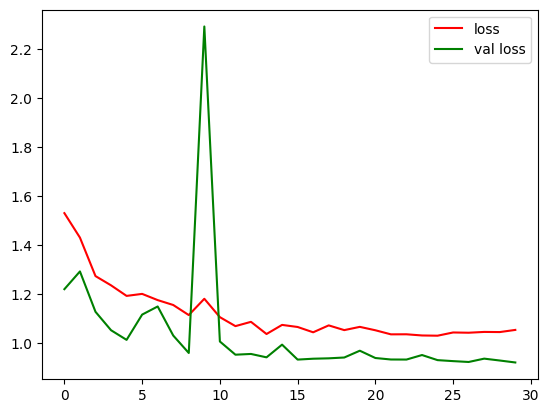

In [71]:
#print(model_history.history['loss'])
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')

plt.show()

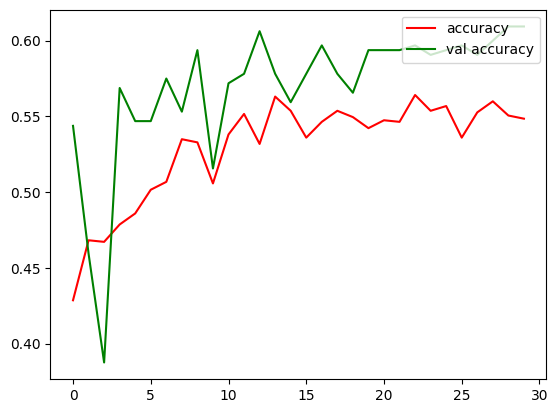

In [72]:
plt.plot(model_history.history['categorical_accuracy'], color = 'red', label = 'accuracy')
plt.plot(model_history.history['val_categorical_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [73]:
score_test= model.evaluate([X_test_num, X_test_img], y_test)

10/10 [==============================] - 2s 68ms/step - loss: 2.5369 - categorical_accuracy: 0.4906 - precision: 0.4906 - recall: 0.4906 - auc: 0.7967


In [74]:
prediction = model.predict([X_test_num,X_test_img],)
real_values= np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(prediction, axis = 1)

result = [list(t) for t in zip(predicted_classes, real_values)]
#print(np.round(prediction))


10/10 [==============================] - 1s 43ms/step


In [75]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(real_values, predicted_classes)


<Axes: >

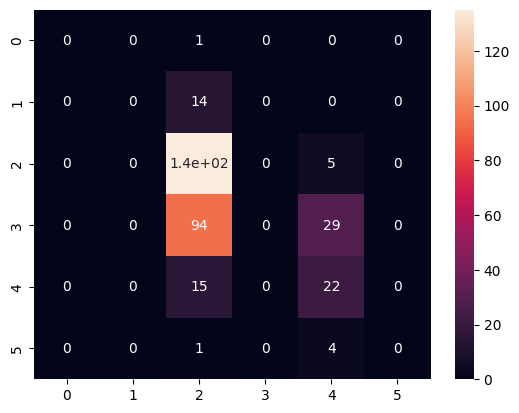

In [76]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [353]:
test_accuracy = score_test[1]
test_auc = score_test[4]
test_precision = score_test[2]
test_recall = score_test[3]

print("Test accuracy:",test_accuracy)
print("Test AUC:",test_auc)
print("Test precision:",test_precision)
print("Test recall:",test_recall)

Test accuracy: 0.9666666388511658
Test AUC: 0.9897221922874451
Test precision: 0.9655172228813171
Test recall: 0.9333333373069763


In [355]:
train_accuracy = model_history.history["categorical_accuracy"][-1]
train_auc = model_history.history["auc"][-1]
train_precision = model_history.history["precision"][-1]
train_recall = model_history.history["recall"][-1]
train_loss = model_history.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.8651685118675232
Train AUC: 0.9656293988227844
Train precision: 0.8735632300376892
Train recall: 0.8539325594902039
Train loss: 0.348810076713562


In [356]:
validation_accuracy = model_history.history["val_categorical_accuracy"][-1]
validation_auc = model_history.history["val_auc"][-1]
validation_precision = model_history.history["val_precision"][-1]
validation_recall = model_history.history["val_recall"][-1]
validation_loss = model_history.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.7333333492279053
Validation AUC: 0.9027777910232544
Validation precision: 0.7333333492279053
Validation recall: 0.7333333492279053
Validation loss: 1.2811261415481567


## Tx4 Dataset

### Data Loading

In [357]:
#Select the model and the parameters
# problem_type: supervised, unsupervised or regeression
problem_type = "supervised"
# default TINTO image 20x20
image_model = TINTO(problem= problem_type,blur=True)
pixel_size = 20

#Define the dataset path and the folder where the images will be saved
dataset_path = "./data_files/Tx_4.csv"
images_folder = "HyNNImages/Classification/TX_4Classification"

In [358]:
#Read CSV
df = pd.read_csv(dataset_path)
df.head(2)

,B1,B2,B3,B4,B5,B6,Sector
0,-60,-88,-78,-76,-91,-76,1
1,-60,-75,-76,-74,-88,-74,1


In [359]:
#Generate thet images
image_model.generateImages(df, images_folder)
img_paths = os.path.join(images_folder,problem_type+".csv")
print(img_paths)

HyNNImages/Classification/TX_4Classification\supervised.csv


In [360]:
# Read images
imgs = pd.read_csv(img_paths)

imgs["images"]= images_folder + "/" + imgs["images"]

In [361]:
imgs.head(2)

,images,class
0,HyNNImages/Classification/TX_4Classification/0...,1
1,HyNNImages/Classification/TX_4Classification/0...,1


In [362]:
# Select all the attributes to normalize
columns_to_normalize = df.columns[:-1]

# Normalize between 0 and 1
df_normalized = (df[columns_to_normalize] - df[columns_to_normalize].min()) / (df[columns_to_normalize].max() - df[columns_to_normalize].min())

# Combine the attributes and the label
df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

df_normalized.head(2)

,B1,B2,B3,B4,B5,B6,Sector
0,0.913043,0.304348,0.468085,0.562500,0.244444,0.56,1
1,0.913043,0.586957,0.510638,0.604167,0.311111,0.60,1


In [363]:
combined_dataset = pd.concat([imgs,df_normalized],axis=1)

In [364]:
combined_dataset.head(2)

,images,class,B1,B2,B3,B4,B5,B6,Sector
0,HyNNImages/Classification/TX_4Classification/0...,1,0.913043,0.304348,0.468085,0.562500,0.244444,0.56,1
1,HyNNImages/Classification/TX_4Classification/0...,1,0.913043,0.586957,0.510638,0.604167,0.311111,0.60,1


In [365]:
combined_dataset = pd.concat([imgs,df_normalized],axis=1)
# df_x drop the class and label columns
df_x = combined_dataset.drop("class",axis=1).drop("Sector",axis=1)
# df_y get class column
df_y = combined_dataset["class"]

print(df_y)

0        1
1        1
2        1
3        1
4        1
        ..
2795    28
2796    28
2797    28
2798    28
2799    28
Name: class, Length: 2800, dtype: int64


In [366]:
# Encode class values as integers, when multi-class classification problem
from tensorflow.keras.utils import to_categorical

encoder = sklearn.preprocessing.LabelEncoder()
df_y_int = encoder.fit_transform(df_y)

# Now convert integer-encoded labels to one-hot encoding
df_y_onehot = to_categorical(df_y_int)

### Data Splitting

In [367]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y_onehot, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 canal (RGB)
X_train_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_train["images"]])
X_val_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_val["images"]])
X_test_img = np.array([cv2.resize(cv2.imread(img),(pixel_size,pixel_size)) for img in X_test["images"]])

# For 1 canal (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

attributes = len(X_train_num.columns)
imgs_shape = X_train_img[0].shape

print("Images shape: ",imgs_shape)
print("Attributes: ",attributes)
pixels=X_train_img[0].shape[0]
print("Image size (pixels):", pixels)

Images shape:  (20, 20, 3)
Attributes:  6
Image size (pixels): 20


### Training

In [368]:
X_train_num.shape

(1680, 6)

In [369]:
# CPU only
X_train_img = tf.cast(X_train_img, tf.float32)

In [370]:
X_train_img.shape

TensorShape([1680, 20, 20, 3])

In [371]:
num_classes = y_train.shape[1]

In [372]:
y_train.shape

(1680, 28)

In [373]:
model = HNNRestNetModel(
    filters_ffnn=[128,64,32],
    dropout_rate=0.1,
    attention_num_heads=10,
    attention_key_dim=20,
    attention_value_dim=20,
    attention_output_dim=20,
    attention_dropout=0.1,
    ffn_hidden_size=512,
    encoder_num_layers=3,
    num_classes=num_classes,
    attention_use_bias=False,
)

In [374]:
METRICS = [
    #tf.keras.metrics.TruePositives(name = 'tp'),
    #tf.keras.metrics.FalsePositives(name = 'fp'),
    #tf.keras.metrics.TrueNegatives(name = 'tn'),
    #tf.keras.metrics.FalseNegatives(name = 'fn'),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

In [375]:
#HYPERPARAMETERS
opt = Adam()
#opt=SGD(learning_rate=1e-4, momentum=0.9)

In [376]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics = METRICS
)
epochs = 100

In [377]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=20, mode="max" ,restore_best_weights=True)

model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=epochs ,
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/100


210/210 [==============================] - 18s 47ms/step - loss: 3.4253 - categorical_accuracy: 0.0405 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5179 - val_loss: 3.3550 - val_categorical_accuracy: 0.0321 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5037
Epoch 2/100
210/210 [==============================] - 8s 39ms/step - loss: 3.2553 - categorical_accuracy: 0.0863 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6112 - val_loss: 3.2641 - val_categorical_accuracy: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6008
Epoch 3/100
210/210 [==============================] - 8s 40ms/step - loss: 3.1232 - categorical_accuracy: 0.1208 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6783 - val_loss: 3.0028 - val_categorical_accuracy: 0.1768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7391
Epoch 4/100
210/210 [==============================] - 9s 42ms/step - loss: 2.9759 - categorical_accuracy: 0.1470 - p

In [380]:
print(model_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_auc'])


### Test & Val

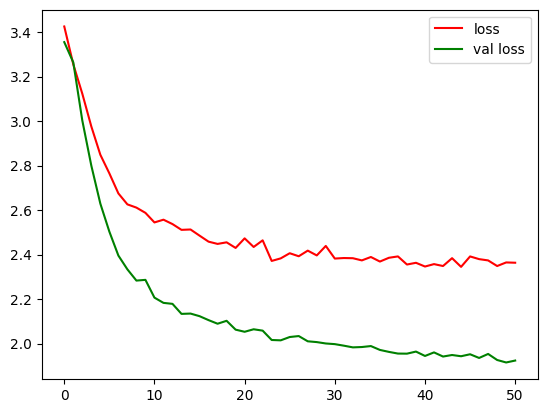

In [381]:
#print(model_history.history['loss'])
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')

plt.show()

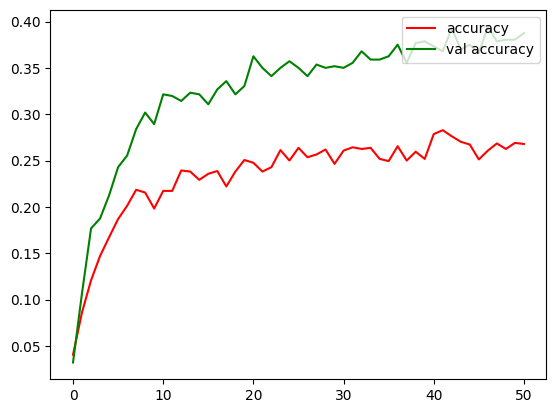

In [382]:
plt.plot(model_history.history['categorical_accuracy'], color = 'red', label = 'accuracy')
plt.plot(model_history.history['val_categorical_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [383]:
score_test= model.evaluate([X_test_num, X_test_img], y_test)

18/18 [==============================] - 2s 32ms/step - loss: 1.9608 - categorical_accuracy: 0.3607 - precision: 0.7455 - recall: 0.0732 - auc: 0.9246


In [384]:
prediction = model.predict([X_test_num,X_test_img],)
real_values= np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(prediction, axis = 1)

result = [list(t) for t in zip(predicted_classes, real_values)]
#print(np.round(prediction))


18/18 [==============================] - 1s 31ms/step


In [385]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy
accuracy = accuracy_score(real_values, predicted_classes)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 36.07%


In [386]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(real_values, predicted_classes)


<Axes: >

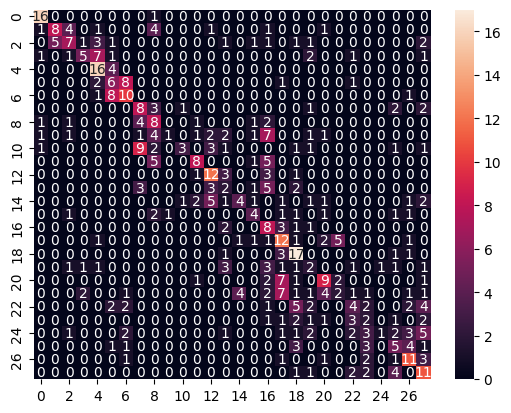

In [387]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [388]:
test_accuracy = score_test[1]
test_auc = score_test[4]
test_precision = score_test[2]
test_recall = score_test[3]

print("Test accuracy:",test_accuracy)
print("Test AUC:",test_auc)
print("Test precision:",test_precision)
print("Test recall:",test_recall)

Test accuracy: 0.36071428656578064
Test AUC: 0.9245873689651489
Test precision: 0.7454545497894287
Test recall: 0.07321428507566452


In [390]:
train_accuracy = model_history.history["categorical_accuracy"][-1]
train_auc = model_history.history["auc"][-1]
train_precision = model_history.history["precision"][-1]
train_recall = model_history.history["recall"][-1]
train_loss = model_history.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.2678571343421936
Train AUC: 0.8674831390380859
Train precision: 0.6000000238418579
Train recall: 0.03928571566939354
Train loss: 2.363319158554077


In [391]:
validation_accuracy = model_history.history["val_categorical_accuracy"][-1]
validation_auc = model_history.history["val_auc"][-1]
validation_precision = model_history.history["val_precision"][-1]
validation_recall = model_history.history["val_recall"][-1]
validation_loss = model_history.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.38749998807907104
Validation AUC: 0.9281799793243408
Validation precision: 0.6065573692321777
Validation recall: 0.06607142835855484
Validation loss: 1.923590064048767
